In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

import tensorflow as tf
import numpy as np
from numpy import expand_dims
from numpy import zeros, ones
from numpy.random import randn
from numpy.random import randint
from tensorflow.keras.optimizers import Adam,RMSprop
# from keras.optimizers import Adam,RMSprop
# from keras.layers.advanced_activations import LeakyReLU,ReLU
from tensorflow.keras.layers import ELU,PReLU,LeakyReLU,ReLU
from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import Dense,Reshape,Flatten,Conv2D,MaxPooling2D,Dropout,BatchNormalization,Conv2DTranspose
import matplotlib.pyplot as plt
import scipy.io
from scipy.io import loadmat
from tensorflow.keras.initializers import RandomNormal
from IPython.display import set_matplotlib_formats

#set_matplotlib_formats('png', 'pdf') ## deprecated since IPython 7.23
import matplotlib_inline.backend_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('png', 'pdf')

#from time import sleep
import sys


In [2]:
print(tf.__version__)
os.environ["KERAS_BACKEND"] = "tensorflow"
np.random.seed(10)
Y_noisy=scipy.io.loadmat('In_Data.mat');
Y_noisy = np.array(list(Y_noisy.values())[3])
Channels=scipy.io.loadmat('Out_Data.mat');
Channels = np.array(list(Channels.values())[3])
print(Y_noisy.shape)
print(Channels.shape)

2.4.1
(4000, 64, 8, 2)
(4000, 64, 8, 2)


In [3]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 12868856181313031498
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 11763561280
locality {
  bus_id: 1
  links {
    link {
      device_id: 1
      type: "StreamExecutor"
      strength: 1
    }
  }
}
incarnation: 15350461801192287260
physical_device_desc: "device: 0, name: NVIDIA TITAN Xp, pci bus id: 0000:01:00.0, compute capability: 6.1"
, name: "/device:GPU:1"
device_type: "GPU"
memory_limit: 11763684480
locality {
  bus_id: 1
  links {
    link {
      type: "StreamExecutor"
      strength: 1
    }
  }
}
incarnation: 426290574568257850
physical_device_desc: "device: 1, name: NVIDIA TITAN Xp, pci bus id: 0000:02:00.0, compute capability: 6.1"
]
Num GPUs Available:  2


In [4]:
# design Discriminator
Input_shape=(64,8,2) # The input size if Discriminator

# Discriminator network structure
def define_discriminator(Input_shape):
    init = RandomNormal(mean=0, stddev=0.02)
    model=Sequential()

    model.add(Conv2D(64,kernel_size=4,strides=2,input_shape=Input_shape,
                             padding='same',kernel_initializer=init))
    model.add(BatchNormalization())
    model.add(LeakyReLU(0.2))
    model.add(Dropout(rate = 0.4))

    model.add(Conv2D(128,kernel_size=4,strides=2,padding='same',kernel_initializer=init))
    model.add(BatchNormalization())
    model.add(LeakyReLU(0.2))
    model.add(Dropout(rate = 0.5))

    model.add(Conv2D(256,kernel_size=4,strides=2,padding='same',kernel_initializer=init))
    model.add(BatchNormalization())
    model.add(LeakyReLU(0.2))
    model.add(Dropout(rate = 0.4))

    model.add(Conv2D(512,kernel_size=4,strides=2,padding='same',kernel_initializer=init))
    model.add(BatchNormalization())
    model.add(LeakyReLU(0.2))
    model.add(Dropout(rate = 0.4))

    model.add(Flatten())
    model.add(Dense(1,activation='linear'))

    model.compile(loss='mean_squared_error',optimizer=Adam(lr=0.0002, beta_1=0.5),
                          metrics=['accuracy'])
    return model
Figure1=define_discriminator(Input_shape)
Figure1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 4, 64)         2112      
_________________________________________________________________
batch_normalization (BatchNo (None, 32, 4, 64)         256       
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 32, 4, 64)         0         
_________________________________________________________________
dropout (Dropout)            (None, 32, 4, 64)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 2, 128)        131200    
_________________________________________________________________
batch_normalization_1 (Batch (None, 16, 2, 128)        512       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 16, 2, 128)        0

In [5]:
# design autoencoder as generator
Input = (64,8,2)

# Generator network structure
def define_generator(Input_shape):
    init = RandomNormal(mean=0, stddev=0.02)
    model=Sequential()
    # Encoder
    model.add(Conv2D(128,kernel_size=4,strides=2,input_shape=Input_shape,padding='same',kernel_initializer=init))
    model.add(ReLU(0.2))
    model.add(BatchNormalization())

    model.add(Conv2D(128,kernel_size=4,strides=1,input_shape=Input_shape,padding='same',kernel_initializer=init))
    model.add(ReLU(0.2))
    model.add(BatchNormalization())

    model.add(Conv2D(64,kernel_size=4,strides=2,padding='same',kernel_initializer=init))
    model.add(ReLU(0.2))
    model.add(BatchNormalization())

    model.add(Conv2D(32,kernel_size=4,strides=2,padding='same',kernel_initializer=init))
    model.add(ReLU(0.2))
    model.add(BatchNormalization())


    # Decoder
    model.add(Conv2DTranspose(32,kernel_size=4,strides=2,padding='same',kernel_initializer=init))
    model.add(ReLU(0.2))
    model.add(BatchNormalization())

    model.add(Conv2DTranspose(64,kernel_size=4,strides=1,padding='same',kernel_initializer=init))
    model.add(ReLU(0.2))
    model.add(BatchNormalization())

    model.add(Conv2DTranspose(128,kernel_size=4,strides=2,padding='same',kernel_initializer=init))
    model.add(BatchNormalization())
    model.add(ReLU(0.2))

    model.add(Conv2DTranspose(2,kernel_size=4,strides=2,activation='tanh',padding='same',kernel_initializer=init))
    #generator.compile(loss='binary_crossentropy',optimizer=Adam(lr=0.0002,beta_1=0.5))

    return model
Figure2=define_generator(Input)
Figure2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 32, 4, 128)        4224      
_________________________________________________________________
re_lu (ReLU)                 (None, 32, 4, 128)        0         
_________________________________________________________________
batch_normalization_4 (Batch (None, 32, 4, 128)        512       
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 32, 4, 128)        262272    
_________________________________________________________________
re_lu_1 (ReLU)               (None, 32, 4, 128)        0         
_________________________________________________________________
batch_normalization_5 (Batch (None, 32, 4, 128)        512       
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 16, 2, 64)        

In [6]:
# GAN design
Generator=define_generator(Input)
Discriminator=define_discriminator(Input_shape)
def define_GAN(Generator,Discriminator):
    #Discriminator.trainable=False
    model=Sequential()
    model.add(Generator)
    model.add(Discriminator)
    model.compile(loss='mean_squared_error',optimizer=Adam(learning_rate=0.0002, beta_1=0.5))
    return model
Figure3=define_GAN(Generator,Discriminator)
Figure3.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_2 (Sequential)    (None, 64, 8, 2)          617282    
_________________________________________________________________
sequential_3 (Sequential)    (None, 1)                 2761409   
Total params: 3,378,691
Trainable params: 3,375,619
Non-trainable params: 3,072
_________________________________________________________________


Num_Batch in each epoch: 62
[===========================================================================================================================================================================================================================================================================================================] epoch:299

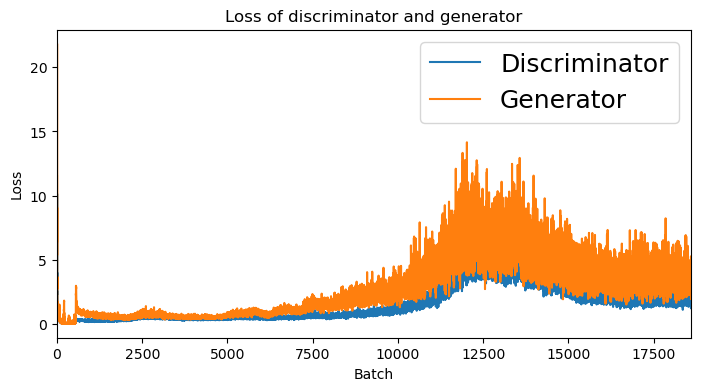

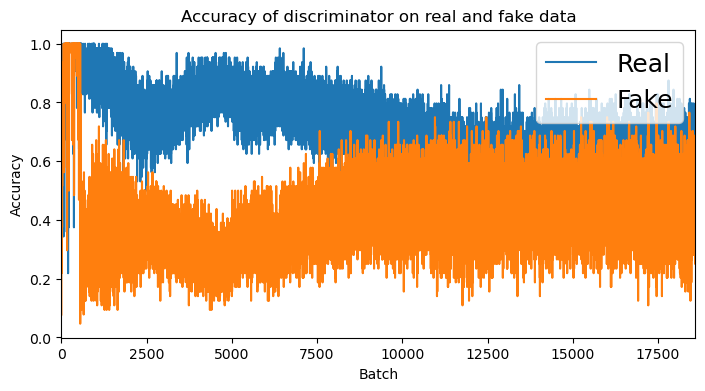

INFO:tensorflow:Assets written to: generator_model/assets
INFO:tensorflow:Assets written to: discriminator_model/assets


In [9]:
# training
def Train(Discriminator, Generator, GAN, Epoch, batch_size):
    # load data
    #Xtrain = np.array([np.array(TrainData[4][ii][0]) for ii in range(len(TrainData[4]))])
    #YTrain = np.array([np.array(TrainData[5][ii][0]) for ii in range(len(TrainData[5]))])
    # add one size to Xtrain
    Y=Y_noisy.reshape(Y_noisy.shape[0],64,8,2)
    H=Channels.reshape(Channels.shape[0],64,8,2)

    #Xtrain=Xtrain.reshape(Xtrain.shape[0],128,400,1)
    Num_Batch=int(Y.shape[0]/batch_size)
    print("Num_Batch in each epoch:",Num_Batch)


    # prepare to save results
    #Rloss=[]
    #Floss=[]
    Raccuracy=list()
    Faccuracy=list()
    Dloss=list()
    #Accuracy=[]
    Gloss=list()


    for i in range(Epoch):
        for j in range (Num_Batch):

            # generate label 1 and 0 for real and fake data respectively
            Real_label=np.ones((batch_size,1))
            Fake_label=np.zeros((batch_size,1))

            # calculating loss and accuracy of discriminator on real and fake data
            Ch_index=np.random.randint(0,H.shape[0],batch_size)
            Real_data=H[Ch_index]

            Y_index=np.random.randint(0,Y.shape[0],batch_size)
            Fake=Y[Y_index]
            Fake_data=Generator.predict(Fake)


            Rloss,Racc=Discriminator.train_on_batch(Real_data,Real_label)
            #_,Racc_temp=discriminator.evaluate(Real_data,Real_label, verbose=0)

            Floss,Facc=Discriminator.train_on_batch(Fake_data,Fake_label)
            #_,Facc_temp=discriminator.evaluate(Fake_data,Fake_label, verbose=0)

            d_loss=0.5*np.add(Rloss,Floss)

            # calculating loss of generator and its training
            #discriminator.trainable=False
            Y_index=np.random.randint(0,Y.shape[0],batch_size)
            Fake=Y[Y_index]
            g_loss=GAN.train_on_batch(Fake,Real_label)

            #discriminator.trainable=True

            # show results for each batch size
#             print("[epoch:%d,batch:%d] [Dloss: %f , Racc: %.2f, Facc: %.2f ] [Gloss: %f]" %
#                    (i,j,d_loss,Racc,Facc,g_loss))

            Dloss.append(d_loss)
            #Accuracy.append((accuracy_temp))
            #Floss.append((Floss_temp))
            Raccuracy.append(Racc)
            Faccuracy.append(Facc)
            Gloss.append(g_loss)

#         print("[epoch:%d] [Dloss: %f , Racc: %.2f, Facc: %.2f ] [Gloss: %f]" %
#                (i,d_loss,Racc,Facc,g_loss))
        sys.stdout.write('\r')
        sys.stdout.write("[Running] epoch:%d / %d" % (i,Epoch))
        #sys.stdout.write("[%-200s] epoch:%d" % ('='*i, i))
        sys.stdout.flush()
    
        # save weights of both networks
        Generator.save('generator.h5')
        Discriminator.save('discriminator.h5')
        Generator.save_weights('weightG.h5')
        Discriminator.save_weights('weightsD.h5')

        
    plt.figure(figsize=(18,4))
    plt.subplot(1,2,1)
    plt.plot(range(Epoch*Num_Batch),Dloss,label='Discriminator')
    plt.plot(range(Epoch*Num_Batch),Gloss,label='Generator')
    #plt.plot(range(Epoch*Num_Batch),Gloss,label='Generator')
    plt.xlabel('Batch')
    plt.xlim(0,Epoch*Num_Batch,10)
    plt.ylabel('Loss')
    plt.title('Loss of discriminator and generator')
    plt.legend(prop={"size":18})
    plt.savefig('Loss.png')
    plt.show()

    plt.figure(figsize=(18,4))
    plt.subplot(1,2,2)
    #plt.plot(range(Epoch*Num_Batch),Accuracy,label='Discriminator')
    plt.plot(range(Epoch*Num_Batch),Raccuracy,label='Real')
    plt.plot(range(Epoch*Num_Batch),Faccuracy,label='Fake')
    plt.xlabel('Batch')
    plt.xlim(0,Epoch*Num_Batch,10)
    plt.ylabel('Accuracy')
    plt.title('Accuracy of discriminator on real and fake data')
    plt.legend(prop={"size":18})
    plt.savefig('Accuracy.png')
    plt.show()


Epoch=200
batch_size=64
Generator=define_generator(Input)
Discriminator=define_discriminator(Input_shape)
GAN=define_GAN(Generator,Discriminator)

Train(Discriminator, Generator, GAN, Epoch, batch_size)
Generator.save('generator_model')
Discriminator.save('discriminator_model')

In [10]:
# uploading trained networks
os.environ["KERAS_BACKEND"] = "tensorflow"
np.random.seed(10)
Attack_Data=scipy.io.loadmat('Test_Data.mat');
Attack_Data = np.array(list(Attack_Data.values())[3])
print(Attack_Data.shape)
Channel_real=scipy.io.loadmat('Test_Channel.mat');
Channel_real = np.array(list(Channel_real.values())[3])
print(Channel_real.shape)

(1000, 64, 8, 2)
(1000, 64, 8, 2)


/tmp/ipykernel_29133/1636329202.py:26: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(realDis, hist=True, kde=True,
/tmp/ipykernel_29133/1636329202.py:35: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(fakeDis, hist=True, kde=True,


[[0.9018979 ]
 [0.90189385]
 [0.90189314]
 [0.9018893 ]
 [0.9018922 ]
 [0.9018891 ]
 [0.90187645]
 [0.9018891 ]
 [0.9018812 ]
 [0.9018891 ]
 [0.9018686 ]
 [0.9018607 ]
 [0.9018891 ]
 [0.90190005]
 [0.901886  ]
 [0.9018979 ]
 [0.90190506]
 [0.9018805 ]
 [0.9018891 ]
 [0.9018891 ]
 [0.9019058 ]
 [0.9019046 ]
 [0.9018884 ]
 [0.9019046 ]
 [0.9018891 ]
 [0.9018979 ]
 [0.9018891 ]
 [0.9019067 ]
 [0.9018636 ]
 [0.9018891 ]
 [0.9018855 ]
 [0.9018891 ]
 [0.9018891 ]
 [0.90189743]
 [0.90186954]
 [0.9018686 ]
 [0.9018891 ]
 [0.901906  ]
 [0.90187335]
 [0.90187645]
 [0.9018891 ]
 [0.9018905 ]
 [0.901881  ]
 [0.90188193]
 [0.9018781 ]
 [0.90188074]
 [0.9018891 ]
 [0.901891  ]
 [0.9018769 ]
 [0.90190554]
 [0.9018917 ]
 [0.9018781 ]
 [0.90189934]
 [0.9018769 ]
 [0.9019058 ]
 [0.9018605 ]
 [0.9018884 ]
 [0.9019058 ]
 [0.9018891 ]
 [0.9018853 ]
 [0.9018934 ]
 [0.9018891 ]
 [0.9018786 ]
 [0.9018891 ]
 [0.90190005]
 [0.9018891 ]
 [0.9018891 ]
 [0.9018891 ]
 [0.90187645]
 [0.9018774 ]
 [0.90188503]
 [0.90

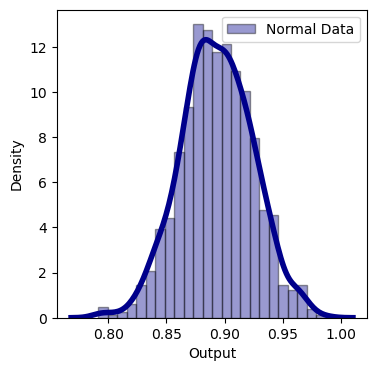

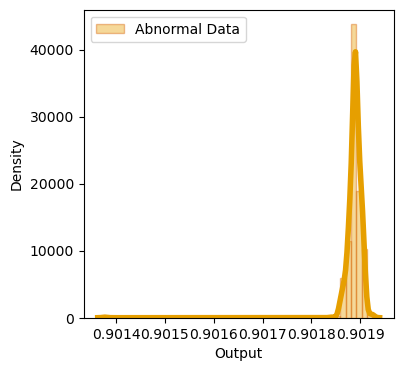

In [11]:
Seed = 0.1
# Load trained networks
from sklearn.metrics import roc_curve, auc, confusion_matrix,accuracy_score
from sklearn.metrics import precision_recall_curve
from tensorflow.keras.models import load_model
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.preprocessing import MinMaxScaler
import random
import math
import seaborn as sns
#Discriminator=define_discriminator(Input_shape)
#Discriminator=load_model('discriminator.h5')
#Generator=define_generator(Input)
#Generator=load_model('generator.h5')
#Discriminator1=tf.keras.models.load_model("discriminator_model")
#Generator1=tf.keras.models.load_model("generator_model")

Estimated_H=Generator.predict(Attack_Data)
realDis=Discriminator.predict(Channel_real)
fakeDis=Discriminator.predict(Estimated_H)

plt.figure(figsize=(4,4))
#plt.subplot(1,2,1)
sns.distplot(realDis, hist=True, kde=True,
             color = 'darkblue',
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4},label='Normal Data')
plt.ylabel('Density')
plt.xlabel('Output')
#plt.xlim(-0.1,0.1,0.01)
plt.legend()
plt.figure(figsize=(4,4))
sns.distplot(fakeDis, hist=True, kde=True,
             color = '#E69F00',
             hist_kws={'edgecolor':'#D55E00'},
             kde_kws={'linewidth': 4},label='Abnormal Data')
plt.ylabel('Density')
plt.xlabel('Output')
plt.legend()
#plt.xlim(-0.01,0.01,0.01)
#plt.xlim('')
#plt.hist(realDis['realDis'], color = 'blue', edgecolor = 'black')
#plt.plot(realDis,'o',label='real')
#plt.ylim(-1,1,0.005)
#plt.show()
#plt.figure(figsize=(18,4))
#plt.subplot(1,2,2)
#plt.plot(fakeDis,'o',label='fake')
#plt.ylim(-0.04,0.02,0.005)
#plt.show()
print(fakeDis)
print(realDis)

[[1.]
 [1.]
 [1.]
 ...
 [1.]
 [1.]
 [1.]]
[[1.]
 [1.]
 [1.]
 ...
 [0.]
 [0.]
 [0.]]
0.5
1.0
0.6666666666666666
0.5
[[   0 1000]
 [   0 1000]]


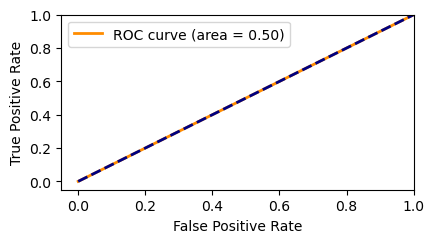

In [12]:
YPredLabel = abs(np.array([realDis, fakeDis]))
YPredLabel[YPredLabel<0.001] = 0
YPredLabel[YPredLabel>=0.001] = 1
YPredLabel.resize(2000,1)
print(YPredLabel)
Ylabel = np.array([ones([1000]), zeros([1000])])
Ylabel.resize(2000,1)
print(Ylabel)
# confusion matrix
Accuracy= confusion_matrix(Ylabel, YPredLabel)
precision = precision_score(Ylabel, YPredLabel, average='binary')
recall = recall_score(Ylabel, YPredLabel, average='binary')
score = f1_score(Ylabel, YPredLabel, average='binary')
print(precision)
print(recall)
print(score)
print(accuracy_score(Ylabel, YPredLabel))
print(Accuracy)
fpr, tpr, threshold = roc_curve(Ylabel, YPredLabel)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(10, 5))
plt.subplot(221)
lw = 2
plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim(-0.05,1,0.2)
plt.ylim(-0.05,1,0.2)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()

[[1.]
 [1.]
 [1.]
 ...
 [1.]
 [1.]
 [1.]]
[[1.]
 [1.]
 [1.]
 ...
 [0.]
 [0.]
 [0.]]
0.5
1.0
0.6666666666666666
[[   0 1000]
 [   0 1000]]
0.5


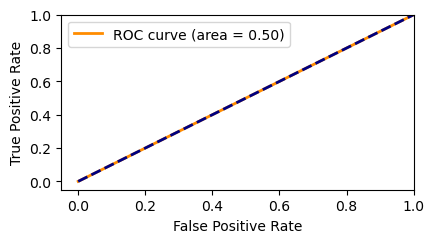

In [13]:
YPredLabel = abs(np.array([realDis, fakeDis]))
YPredLabel[YPredLabel<0.002] = 0
YPredLabel[YPredLabel>=0.002] = 1
YPredLabel.resize(2000,1)
print(YPredLabel)
Ylabel = np.array([ones([1000]), zeros([1000])])
Ylabel.resize(2000,1)
print(Ylabel)
# confusion matrix
Accuracy= confusion_matrix(Ylabel, YPredLabel)
precision = precision_score(Ylabel, YPredLabel, average='binary')
recall = recall_score(Ylabel, YPredLabel, average='binary')
score = f1_score(Ylabel, YPredLabel, average='binary')
print(precision)
print(recall)
print(score)
print(Accuracy)
print(accuracy_score(Ylabel, YPredLabel))
fpr, tpr, threshold = roc_curve(Ylabel, YPredLabel)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(10, 5))
plt.subplot(221)
lw = 2
plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim(-0.05,1,0.2)
plt.ylim(-0.05,1,0.2)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()

[[1.]
 [1.]
 [1.]
 ...
 [1.]
 [1.]
 [1.]]
[[1.]
 [1.]
 [1.]
 ...
 [0.]
 [0.]
 [0.]]
0.5
1.0
0.6666666666666666
0.5
None
[[   0 1000]
 [   0 1000]]


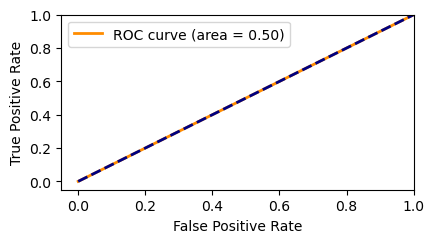

In [14]:
YPredLabel = abs(np.array([realDis, fakeDis]))
YPredLabel[YPredLabel<0.003] = 0
YPredLabel[YPredLabel>=0.003] = 1
YPredLabel.resize(2000,1)
print(YPredLabel)
Ylabel = np.array([ones([1000]), zeros([1000])])
Ylabel.resize(2000,1)
print(Ylabel)
# confusion matrix
Accuracy= confusion_matrix(Ylabel, YPredLabel)
precision = precision_score(Ylabel, YPredLabel, average='binary')
recall = recall_score(Ylabel, YPredLabel, average='binary')
score = f1_score(Ylabel, YPredLabel, average='binary')
print(precision)
print(recall)
print(score)
print(print(accuracy_score(Ylabel, YPredLabel)))
print(Accuracy)
fpr, tpr, threshold = roc_curve(Ylabel, YPredLabel)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(10, 5))
plt.subplot(221)
lw = 2
plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim(-0.05,1,0.2)
plt.ylim(-0.05,1,0.2)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()

[[1.]
 [1.]
 [1.]
 ...
 [1.]
 [1.]
 [1.]]
[[1.]
 [1.]
 [1.]
 ...
 [0.]
 [0.]
 [0.]]
0.5
1.0
0.6666666666666666
0.5
None
[[   0 1000]
 [   0 1000]]


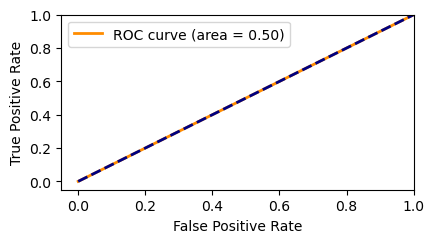

In [15]:
YPredLabel = abs(np.array([realDis, fakeDis]))
YPredLabel[YPredLabel<0.004] = 0
YPredLabel[YPredLabel>=0.004] = 1
YPredLabel.resize(2000,1)
print(YPredLabel)
Ylabel = np.array([ones([1000]), zeros([1000])])
Ylabel.resize(2000,1)
print(Ylabel)
# confusion matrix
Accuracy= confusion_matrix(Ylabel, YPredLabel)
precision = precision_score(Ylabel, YPredLabel, average='binary')
recall = recall_score(Ylabel, YPredLabel, average='binary')
score = f1_score(Ylabel, YPredLabel, average='binary')
print(precision)
print(recall)
print(score)
print(print(accuracy_score(Ylabel, YPredLabel)))
print(Accuracy)
fpr, tpr, threshold = roc_curve(Ylabel, YPredLabel)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(10, 5))
plt.subplot(221)
lw = 2
plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim(-0.05,1,0.2)
plt.ylim(-0.05,1,0.2)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()

[[1.]
 [1.]
 [1.]
 ...
 [1.]
 [1.]
 [1.]]
[[1.]
 [1.]
 [1.]
 ...
 [0.]
 [0.]
 [0.]]
0.5
1.0
0.6666666666666666
[[   0 1000]
 [   0 1000]]
0.5
None


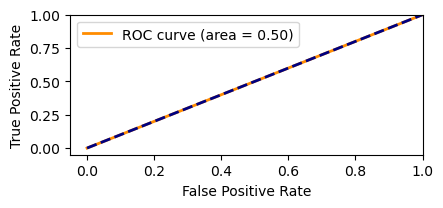

In [16]:
YPredLabel = abs(np.array([realDis, fakeDis]))
YPredLabel[YPredLabel<0.005] = 0
YPredLabel[YPredLabel>=0.005] = 1
YPredLabel.resize(2000,1)
print(YPredLabel)
Ylabel = np.array([ones([1000]), zeros([1000])])
Ylabel.resize(2000,1)
print(Ylabel)
# confusion matrix
Accuracy= confusion_matrix(Ylabel, YPredLabel)
precision = precision_score(Ylabel, YPredLabel, average='binary')
recall = recall_score(Ylabel, YPredLabel, average='binary')
score = f1_score(Ylabel, YPredLabel, average='binary')
print(precision)
print(recall)
print(score)
print(Accuracy)
print(print(accuracy_score(Ylabel, YPredLabel)))
fpr, tpr, threshold = roc_curve(Ylabel, YPredLabel)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(10, 4))
plt.subplot(221)
lw = 2
plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim(-0.05,1,0.2)
plt.ylim(-0.05,1,0.2)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()